---

# 12.2 DeepDream

In [1]:
import os
import pathlib

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from PIL import Image

from IPython.display import display

DeepDream was released by Google in 2015.

It is an algorithm to produce trippy pictures with [pareidolic](https://en.wikipedia.org/wiki/Pareidolia) effects (= meaningful patterns where there is none), such as animals, faces, or simply pattern emerging from any image...

This exploits the inner representation of the ConvNet used, for instance ImageNet, which is replete with animal pictures!

<!-- ![Google DeepDream: Ibis](images/deepdream/google.ibis.png) -->
![Google DeepDream: Ibis](https://raw.githubusercontent.com/jchwenger/AI/main/8-additional-material/images/deepdream/google.ibis.png)

<small>["Inceptionism: Going Deeper into Neural Networks"](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)</small>


<!-- ![Google DeepDream: Ibis](images/deepdream/google.building-dreams.png) -->
![Google DeepDream: Ibis](https://raw.githubusercontent.com/jchwenger/AI/main/8-additional-material/images/deepdream/google.building-dreams.png)

<small>["Inceptionism: Going Deeper into Neural Networks"](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)</small>


The DeepDream algorithm follows the convnet filter visualisation technique we saw in topic 5.

We kept the net fixed and **learnt the image**.

More specifically, we used **gradient ascent on the input image** in order to **maximise** the response of a specific filter in an upper layer.

In this case :

- DeepDream mixes the influence of a large number of features by **maximising the activation of entire layers** rather than a specific filter;
- We **start with an existing image**, not an image of random pixel values, so that the algorithm works with/on pre-existing visual patterns;
- The creators used a scheme with **successive upscalings ("octaves")** of the input image.

---

## 12.2.1 Implementing DeepDream in Keras

### Fetching the test image

156176/156176 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


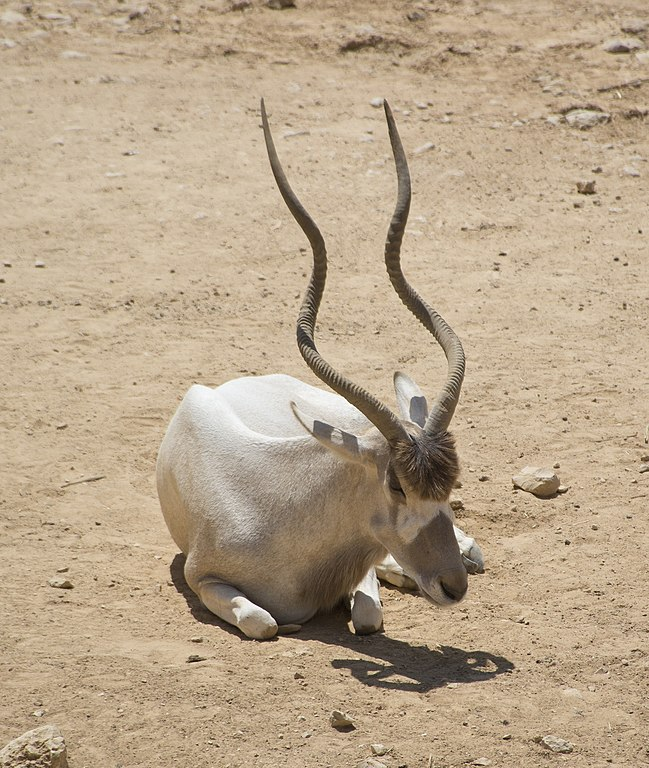

In [2]:
DATASET_DIR = pathlib.Path("deep-dream")
DATASET_DIR.mkdir(exist_ok=True)

base_image_path = tf.keras.utils.get_file(
    # "coast.jpg",
    # origin="https://img-datasets.s3.amazonaws.com/coast.jpg",
    # "labrador.jpg", # https://www.tensorflow.org/tutorials/generative/deepdream
    # origin="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg",
    "addax.jpg",
    origin="https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Addax-Jerusalem-Biblical-Zoo-IZE-611.jpg/649px-Addax-Jerusalem-Biblical-Zoo-IZE-611.jpg",
    cache_dir=DATASET_DIR,
    cache_subdir="",
)

Image.open(base_image_path)

### Instantiating a pretrained `InceptionV3` model

The Keras [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3)

<!-- <img style="float:right" src="images/inceptionv3onc--overview.png"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/blob/main/8-generative-deep-learning/images/inceptionv3onc--overview.png">

<small style="position:absolute;right:0;bottom:0">[Advanced Guide to Inception v3](https://cloud.google.com/tpu/docs/inception-v3-advanced)</small>

In [3]:
model = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [4]:
model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

### Configuring the contribution of each layer to the DeepDream loss

In [5]:
                    # TWEAK ME! (use the summary to get the layer names!)
layer_settings = {  # The names of the layers we will be using
    "mixed3": 1.0,  # as well as their respective weight/importance
    "mixed5": 1.0,  # (how much their reaction counts) in the mix
}

outputs_dict = dict(
    [                                          # we define a new model yielding a dictionary with
        (layer.name, layer.output)             # {"layer name": layer output, ... }
        for layer in [
            model.get_layer(name)              # for all layers selected in `layer_settings`
            for name in layer_settings.keys()
        ]
    ]
)
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict) # functional syntax: our new model

```python
# we can run our image through the feature extractor and get the layer responses
features = feature_extractor(img)
```

### The DeepDream Workflow

Like previously, in filter visualisation, we use **gradient ascent** on our input to **learn the image**.

1. Select the layers we want;
2. Create a new network that return their activations;
3. Run the image through the new network;
4. Take the gradients of the image w.r.t. the activations;
5. Modify the image using said gradients.

The only difference with our earlier visualisation example is that instead of one filter, DeepDream maximises the activation of **all filters in a number of layers simultaneously** (although that could be changed).

### The DeepDream loss

How do we maximize the activations?

We take **the squared norm of each activations** (= an average of how excited it has been), and then take **a weighted sum of all of those** (the numbers above!).

**Note**

Here we use a mix of mid-level layers: lower layers produce in **geometric patterns**, higher layers produce **recognisable features** from ImageNet classes (e.g. animals, objects, etc.).

The exact set of layers has a large influence on the result: it's a **hyperparameter**.

In [6]:
def compute_loss(input_image):
    features = feature_extractor(input_image)                                     # 1. run image through network
    loss = tf.zeros(shape=())                                                     #    (to get activations)
    for name in features.keys():                                                  # 2. for each layer/activation:
        coeff = layer_settings[name]                                              #       extract coefficient (→ weight)
        activation = features[name]                                               #       extract the activation
        # loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :])) # (3. squared norm)
                                                               # ↑ remove border pixels to avoid odd effects
        loss += coeff * tf.reduce_mean(tf.square(activation))                     # (I prefer it with the borders...)
    return loss


### The DeepDream gradient ascent process

In [16]:
@tf.function
def gradient_ascent_step(image, learning_rate):   # GRADIENT COMPUTATION
    with tf.GradientTape() as tape:               # 1. start the operation-tracking
        tape.watch(image)                         #    & watch the image
        loss = compute_loss(image)                # 2. compute the loss (of the image w.r.t. our layers)
    grads = tape.gradient(loss, image)            # 3. compute the gradients
    grads = tf.math.l2_normalize(grads)           #    (trick: l2 normalise the gradients!)
    image += learning_rate * grads                # 4. modify the image (add learning_rate * gradients)
    # image = tf.clip_by_value(image, -1, 1)
    return loss, image

 # 'TRAINING' LOOP
def gradient_ascent_loop(
        image, iterations, learning_rate, max_loss=None, verbose=True
    ):
    for i in range(iterations):                                            # For a number of steps
        loss, image = gradient_ascent_step(image, learning_rate)           #     modify the image using the gradient
        if max_loss is not None and loss > max_loss:                       #     (cut-off mechanism above
            break                                                          #     a certain loss)
        if verbose:
            print(f"... Loss value at step {i+1}: {loss:.2f}\r", end="")
    if verbose:
        print()
    return image

### Octaves

An additional mechanism the authors implemented: repeat the process at different scales.

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)

#### Workflow

1. Define a list of processing **scales** (also called **octaves**).  
   Each successive **scale** is 40% larger than previous one. That percentage is a **hyperparameter**!
2. Run gradient ascent (*learn the image*) on each successive scale.
3. Reinject the original image at each step (for stability: like a **residual layer**!).

### Image processing utilities

In [8]:
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path)                      # load
    img = tf.keras.utils.img_to_array(img)                         # turn into array
    img = np.expand_dims(img, axis=0)                              # add batch dimension
    img = tf.keras.applications.inception_v3.preprocess_input(img) # rescaling to make it compatible with the net
    return img

def deprocess_image(img):
    img = tf.reshape(img, (img.shape[1], img.shape[2], 3))         # remove batch dim
    img /= 2.0                                                     # denormalisation:
    img += 0.5                                                     # Inception has pixels in [-1, 1]:
    img *= 255.                                                    # retransform back to [0,255]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

### Hyperparameters

In [9]:
# Tweak me! ---------------
                             # Chollet:
step = 10                    # 20.  # ← this is the learning rate!
num_octave = 3               # 3
octave_scale = 1.4           # 1.4
iterations = 30              # 30
max_loss = 15.               # 15.  # a cut-off point for our loss
reinject_details = True
display_intermediate = False
# -----------------------------------------------------------------

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

### Building "octaves" shapes

In [10]:
start_power = 1

successive_shapes = [original_shape]                                           # 'OCTAVES'
print("Building shapes:")
print(f"    - {original_shape}")
for i in range(start_power, num_octave+start_power):                           # prepare the shapes in advance,
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])  # going from largest to smallest
    successive_shapes.append(shape) # ↑ we divide by the scale i times
    print(f"    - {original_shape} / octave scale ({octave_scale}) ** {i} (= {octave_scale ** i:.2f}): {shape}")
successive_shapes = successive_shapes[::-1]                                    # then reverse the order

print("---")
print()
print("Successive shapes (reversed):")
print(*[f"    - {sh}" for sh in successive_shapes], sep="\n")
print("-" * 40)

Building shapes:
    - (768, 649)
    - (768, 649) / octave scale (1.4) ** 1 (= 1.40): (548, 463)
    - (768, 649) / octave scale (1.4) ** 2 (= 1.96): (391, 331)
    - (768, 649) / octave scale (1.4) ** 3 (= 2.74): (279, 236)
---

Successive shapes (reversed):
    - (279, 236)
    - (391, 331)
    - (548, 463)
    - (768, 649)
----------------------------------------


#### Note on "octaves" shapes

The "octave" logic is somewhat convoluted, when really what it's doing is gradually increasing the size of the image you are working on. You can simplify the maths by using this code to compute your shapes:

```python
start_mult = .5 # smallest shape: shape * start_mult
end_mult = 1.4  # biggest shape: shape * end_mult
n_octaves = 5   # number of increase steps

successive_shapes = []
# we multiply the shapes by a number ranging from `start_mult` to `end_mult`:
# if the number is smaller than one, it reduces the shape, otherwise it increases it
for i in tf.linspace(start_mult, end_mult, n_octaves):
    shape = tuple([int(dim * i) for dim in original_shape]) # creating new shape
    successive_shapes.append(shape)
```

### Running gradient ascent over multiple successive "octaves"

Processing octave 1 with shape (279, 236)
... Loss value at step 30: 8.73

Processing octave 2 with shape (391, 331)
... Loss value at step 30: 9.01

Processing octave 3 with shape (548, 463)
... Loss value at step 30: 7.64

Processing octave 4 with shape (768, 649)
... Loss value at step 26: 14.04



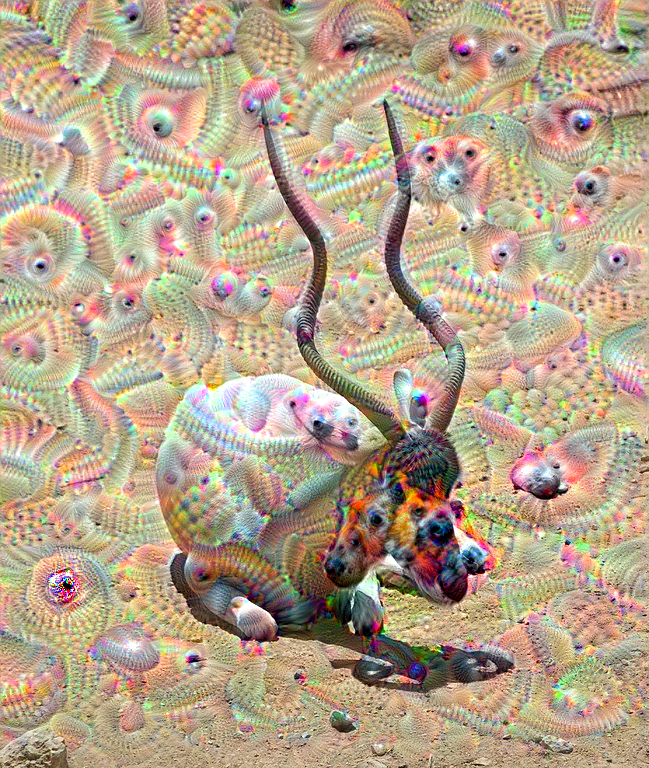

In [22]:
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])          # START: resize to smallest

img = tf.identity(original_img) # just a copy
for i, shape in enumerate(successive_shapes):                                      # DREAM
    print(f"Processing octave {i+1} with shape {shape}")
    img = tf.image.resize(img, shape)                                              # 1. resize
    img = gradient_ascent_loop(                                                    # 2. learn the image at this scale
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    if reinject_details:
        upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape) # 3. lost detail: the difference
        same_size_original = tf.image.resize(original_img, shape)                  #    between the downscaled original
        lost_detail = same_size_original - upscaled_shrunk_original_img            #    & the upscaled shrunk original
        img += lost_detail                                                         #    readded to our dream
        shrunk_original_img = same_size_original                                   #    (prepare shrunk for next loop)

    if display_intermediate and i+1 < num_octave:
        display(Image.fromarray(deprocess_image(img)))

    print()

display(Image.fromarray(deprocess_image(img)))

SAVE = False
if SAVE:
    RESULTS_DIR = DATASET_DIR / "results"
    RESULTS_DIR.mkdir(exist_ok=True)
    fname = RESULTS_DIR / "dream.png"
    tf.keras.utils.save_img(fname, deprocess_image(img.numpy()))

To display

```python
Image.open(fname)
```

### Experiments

- Tweak various **layers**:
    - lower layers produce **geometric patterns**;
    - upper layers are more **specific** (noses, feathers, eyes etc.)

- Try **different convnets** (for a variety of learned features), `Keras` has many on offer:
    - VGG16;
    - VGG19;
    - Xception;
    - ResNet50...  
     (The [list of `tf.keras.applications` models](https://www.tensorflow.org/api_docs/python/tf/keras/applications))

- One cool experiment would be to modify the loss to make it more specific: what would happen if we take the gradient of the image not w.r.t. to an entire layer, but of a single unit (especially one later in the net)?

- Have a look at the [official Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/deepdream), that has a slightly different implementation, and especially the end, with a tiled version!
    


### Further experiments

- Refactor the code so that it is *really* easy for you to change parameters and rerun the code, allowing you to explore the space of possibilites as smoothly as possible.
- If you had a classifier for e.g. types of sound, it might be possible to run this algorithm on audio samples?
- Save and visualise images at **intermediate steps** and test the different parameters to see what each one is doing. You could even try to save all intermediate steps and **combine the images into videos or gifs**.
- Run **grid/random search** on the parameters??
- Create an interactive framework that could run one step, with options to redo the step with different parameters, or undo and go back to the previous stage (= **babysitting**).

---

### 12.2.2 Wrapping up

- DeepDream runs a convnet **in reverse** (**learns the image**) to generate psychedelic images based on learned representations;
- The process is not specific to convnets or even to images (it could theoretically be done with speech, music...) since it merely attempts to increase the activation of layers by **gradient ascent**.

## Reference

["Inceptionism: Going Deeper into Neural Networks"](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)

See Benjamin Badger, ["Feature Visualization II: Deep Dream"](https://blbadger.github.io/deep-dream.html) \(also: ["Feature Visualization I: Feature Maps"](https://blbadger.github.io/feature-visualization.html)).

More recent approach with a similar flavour by NVidia: [DeepInversion](https://github.com/NVlabs/DeepInversion/tree/master?tab=readme-ov-file) \(in PyTorch, [paper](https://arxiv.org/abs/1912.08795)\).